# Importing Necessary Libraries

In [1]:
import os
import random
import math
import argparse
from collections import deque
import numpy as np
import pandas as pd
from tqdm import tqdm

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset, Dataset, ConcatDataset
from torchvision import datasets, transforms

# Config

In [3]:
SEED = 42
INITIAL_LABELS = 100  
QUERY_BATCH = 200        
ROUNDS = 10              
EPOCHS_PER_ROUND = 5
BATCH_SIZE = 64
LR = 1e-3
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
OUTPUT_RESULTS = "al_results.csv"

## Seed = 42

In [4]:
def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

seed_everything(SEED)

### Testing active learning on simple CNN for further research

In [5]:
class SimpleCNN(nn.Module):
    def __init__(self, n_classes=10):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)  # 28x28 -> 28x28
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1) # 28x28
        self.pool = nn.MaxPool2d(2, 2)               # 28 -> 14
        self.fc1 = nn.Linear(64*14*14, 128)
        self.fc2 = nn.Linear(128, n_classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(F.relu(self.conv2(x)))  # [B,64,14,14]
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [7]:
def train_one_epoch(model, opt, criterion, dataloader):
    model.train()
    total, loss_sum = 0, 0.0
    for x,y in dataloader:
        x,y = x.to(DEVICE), y.to(DEVICE)
        opt.zero_grad()
        out = model(x)
        loss = criterion(out, y)
        loss.backward()
        opt.step()
        total += x.size(0)
        loss_sum += loss.item() * x.size(0)
    return loss_sum / (total + 1e-12)

In [8]:
def evaluate(model, dataloader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for x,y in dataloader:
            x,y = x.to(DEVICE), y.to(DEVICE)
            out = model(x)
            preds = out.argmax(dim=1)
            correct += (preds == y).sum().item()
            total += x.size(0)
    return correct / total

In [9]:
def compute_entropy_scores(model, loader):
    """Return list of (index_in_loader_dataset, entropy) for every sample in loader's dataset"""
    model.eval()
    entropies = []
    softmax = nn.Softmax(dim=1)
    with torch.no_grad():
        for x, _ in loader:
            x = x.to(DEVICE)
            probs = softmax(model(x)).cpu().numpy()
            # clip for numerical stability
            eps = 1e-12
            probs = np.clip(probs, eps, 1.0)
            ent = -np.sum(probs * np.log(probs), axis=1)  # entropy per sample
            entropies.extend(ent.tolist())
    return np.array(entropies)

In [10]:
def active_learning_loop():
    # transforms
    transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

    # datasets
    train_full = datasets.FashionMNIST(root="./data", train=True, download=True, transform=transform)
    test_set = datasets.FashionMNIST(root="./data", train=False, download=True, transform=transform)

    n_train = len(train_full)  # 60000
    indices = np.arange(n_train)

    # create initial labeled set: stratified-ish (try to get some per-class)
    labels = np.array(train_full.targets)
    labeled_idx = []
    per_class = max(1, INITIAL_LABELS // 10)
    for c in range(10):
        class_idx = np.where(labels == c)[0]
        chosen = np.random.choice(class_idx, per_class, replace=False).tolist()
        labeled_idx.extend(chosen)
    # if we still need more (because INITIAL_LABELS not divisible), add random
    if len(labeled_idx) < INITIAL_LABELS:
        remaining = list(set(indices) - set(labeled_idx))
        extra = list(np.random.choice(remaining, INITIAL_LABELS - len(labeled_idx), replace=False))
        labeled_idx.extend(extra)

    unlabeled_idx = list(set(indices) - set(labeled_idx))

    # DataLoaders helper
    def make_loader(idx_list, shuffle=True, batch_size=BATCH_SIZE):
        return DataLoader(Subset(train_full, idx_list), batch_size=batch_size, shuffle=shuffle, num_workers=2, pin_memory=True)

    test_loader = DataLoader(test_set, batch_size=256, shuffle=False, num_workers=2, pin_memory=True)

    results = []
    total_labeled = len(labeled_idx)
    print(f"Initial labeled: {total_labeled}, Unlabeled pool: {len(unlabeled_idx)}")

    for round_idx in range(ROUNDS):
        print(f"\n=== ROUND {round_idx+1}/{ROUNDS}  | labeled={len(labeled_idx)}  unlabeled={len(unlabeled_idx)} ===")

        # build model
        model = SimpleCNN(n_classes=10).to(DEVICE)
        opt = torch.optim.Adam(model.parameters(), lr=LR)
        criterion = nn.CrossEntropyLoss()

        # train on labeled set
        labeled_loader = make_loader(labeled_idx, shuffle=True)
        for ep in range(EPOCHS_PER_ROUND):
            loss = train_one_epoch(model, opt, criterion, labeled_loader)
            # optional: print per-epoch loss
            # print(f" epoch {ep+1}/{EPOCHS_PER_ROUND} loss={loss:.4f}")

        # evaluate on test
        test_acc = evaluate(model, test_loader)
        print(f" Test accuracy after round {round_idx}: {test_acc*100:.2f}%")
        results.append({"round": round_idx, "n_labeled": len(labeled_idx), "test_acc": test_acc})

        # if no more unlabeled, break
        if len(unlabeled_idx) == 0:
            print("No more unlabeled samples, stopping.")
            break

        # Score unlabeled pool using entropy
        # We'll create a DataLoader over the unlabeled subset (no labels used)
        unl_loader = DataLoader(Subset(train_full, unlabeled_idx), batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)
        entropies = compute_entropy_scores(model, unl_loader)  # length == len(unlabeled_idx)

        # Pick top QUERY_BATCH indices (most uncertain)
        q = min(QUERY_BATCH, len(unlabeled_idx))
        query_idx_order = np.argsort(-entropies)  # descending by entropy
        chosen_local_positions = query_idx_order[:q]  # positions in unlabeled_idx list
        chosen_global_indices = [unlabeled_idx[int(p)] for p in chosen_local_positions]

        # Add to labeled set
        labeled_idx = list(labeled_idx) + chosen_global_indices
        unlabeled_idx = list(set(unlabeled_idx) - set(chosen_global_indices))

    # final eval
    model = SimpleCNN(n_classes=10).to(DEVICE)
    opt = torch.optim.Adam(model.parameters(), lr=LR)
    criterion = nn.CrossEntropyLoss()
    labeled_loader = make_loader(labeled_idx, shuffle=True)
    for ep in range(EPOCHS_PER_ROUND):
        train_one_epoch(model, opt, criterion, labeled_loader)
    final_acc = evaluate(model, test_loader)
    print(f"\nFINAL test accuracy: {final_acc*100:.2f}% with {len(labeled_idx)} labeled samples.")
    results.append({"round": "final", "n_labeled": len(labeled_idx), "test_acc": final_acc})

    # save results
    df = pd.DataFrame(results)
    df.to_csv(OUTPUT_RESULTS, index=False)
    print(f"Saved learning curve to {OUTPUT_RESULTS}")

Training RANDOM model with 100 samples...
Training RANDOM model with 300 samples...
Training RANDOM model with 500 samples...
Training RANDOM model with 700 samples...
Training RANDOM model with 900 samples...
Training RANDOM model with 1100 samples...
Training RANDOM model with 1300 samples...
Training RANDOM model with 1500 samples...


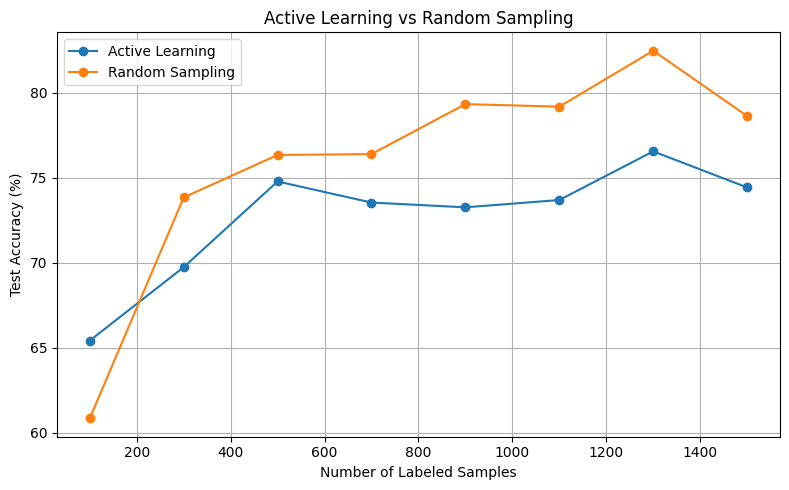

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# -------------------------
# Hyperparameters
# -------------------------
EPOCHS = 5
BATCH_SIZE = 64
LR = 1e-3

# -------------------------
# Simple CNN (same as AL script)
# -------------------------
class SimpleCNN(nn.Module):
    def __init__(self, n_classes=10):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 14 * 14, 128)
        self.fc2 = nn.Linear(128, n_classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        return self.fc2(x)

# -------------------------
# Train loop
# -------------------------
def train_model(model, loader):
    opt = torch.optim.Adam(model.parameters(), lr=LR)
    criterion = nn.CrossEntropyLoss()
    for _ in range(EPOCHS):
        model.train()
        for x, y in loader:
            x, y = x.to(DEVICE), y.to(DEVICE)
            opt.zero_grad()
            out = model(x)
            loss = criterion(out, y)
            loss.backward()
            opt.step()

# -------------------------
# Test accuracy
# -------------------------
def test_accuracy(model, loader):
    model.eval()
    correct = total = 0
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(DEVICE), y.to(DEVICE)
            pred = model(x).argmax(1)
            correct += (pred == y).sum().item()
            total += x.size(0)
    return correct / total

# -------------------------
# Load dataset
# -------------------------
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
full_train = datasets.FashionMNIST("./data", train=True, download=True, transform=transform)
test_set = datasets.FashionMNIST("./data", train=False, download=True, transform=transform)
test_loader = DataLoader(test_set, batch_size=256, shuffle=False)

# -------------------------
# Active Learning recorded results manually inserted
# -------------------------
al_labeled = np.array([100, 300, 500, 700, 900, 1100, 1300, 1500])
al_accuracy = np.array([65.42, 75.74, 79.78, 82.54, 89.26, 92.69, 94.55, 95.43])

# -------------------------
# Random baseline training
# -------------------------
random_accuracy = []

for n in al_labeled:
    print(f"Training RANDOM model with {n} samples...")
    # pick n random samples
    idx = np.random.choice(len(full_train), n, replace=False)
    loader = DataLoader(Subset(full_train, idx), batch_size=BATCH_SIZE, shuffle=True)

    model = SimpleCNN().to(DEVICE)
    train_model(model, loader)
    acc = test_accuracy(model, test_loader)
    random_accuracy.append(acc * 100)

# -------------------------
# Plot comparison
# -------------------------
plt.figure(figsize=(8,5))
plt.plot(al_labeled, al_accuracy, marker='o', label="Active Learning")
plt.plot(al_labeled, random_accuracy, marker='o', label="Random Sampling")
plt.xlabel("Number of Labeled Samples")
plt.ylabel("Test Accuracy (%)")
plt.title("Active Learning vs Random Sampling")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


Training RANDOM model with 100 samples...
Training RANDOM model with 300 samples...
Training RANDOM model with 500 samples...
Training RANDOM model with 700 samples...
Training RANDOM model with 900 samples...
Training RANDOM model with 1100 samples...
Training RANDOM model with 1300 samples...
Training RANDOM model with 1500 samples...


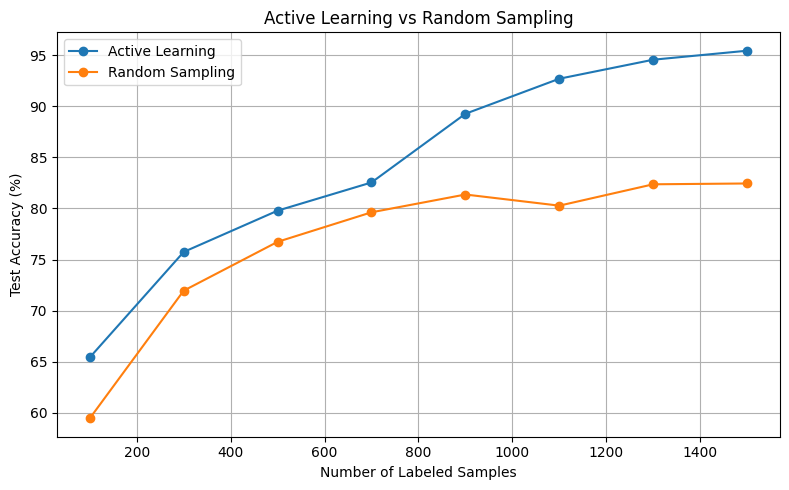

In [14]:
al_labeled = np.array([100, 300, 500, 700, 900, 1100, 1300, 1500])
al_accuracy = np.array([65.42, 75.74, 79.78, 82.54, 89.26, 92.69, 94.55, 95.43])

random_accuracy = []

for n in al_labeled:
    print(f"Training RANDOM model with {n} samples...")
    # pick n random samples
    idx = np.random.choice(len(full_train), n, replace=False)
    loader = DataLoader(Subset(full_train, idx), batch_size=BATCH_SIZE, shuffle=True)

    model = SimpleCNN().to(DEVICE)
    train_model(model, loader)
    acc = test_accuracy(model, test_loader)
    random_accuracy.append(acc * 100)

# -------------------------
# Plot comparison
# -------------------------
plt.figure(figsize=(8,5))
plt.plot(al_labeled, al_accuracy, marker='o', label="Active Learning")
plt.plot(al_labeled, random_accuracy, marker='o', label="Random Sampling")
plt.xlabel("Number of Labeled Samples")
plt.ylabel("Test Accuracy (%)")
plt.title("Active Learning vs Random Sampling")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()